In [1]:
import tensorflow as tf
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


/home/kanchana/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
X=tf.placeholder(tf.float32, shape=[None,784])
y=tf.placeholder(tf.float32,shape=[None,10])


In [3]:
W=tf.Variable(tf.zeros([784,10]))
b=tf.Variable(tf.zeros([10]))

In [4]:
with open('Data/train_X.p', 'rb') as f:
    train_X = pickle.load(f)
with open('Data/train_y.p', 'rb') as f:
    train_y = pickle.load(f)
with open('Data/test_X.p', 'rb') as f:
    test_X = pickle.load(f)
with open('Data/test_y.p', 'rb') as f:
    test_y = pickle.load(f)
with open('Data/val_X.p', 'rb') as f:
    val_X = pickle.load(f)
with open('Data/val_y.p', 'rb') as f:
    val_y = pickle.load(f)

In [5]:
train_X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_y.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


In [7]:
print("Shape of train_X:",train_X.shape)
print("Shape of train_y:",train_y.shape)
print("Shape of val_X:",val_X.shape)
print("Shape of val_y:",val_y.shape)
print("Shape of test_X:",test_X.shape)
print("Shape of test_y:",test_y.shape)

Shape of train_X: (55000, 784)
Shape of train_y: (55000, 10)
Shape of val_X: (5000, 784)
Shape of val_y: (5000, 10)
Shape of test_X: (10000, 784)
Shape of test_y: (10000, 10)


In [8]:
mean_image = np.mean(train_X, axis=0)
train_X -= mean_image
val_X -= mean_image
test_X -= mean_image

#std=StandardScaler()
#std.fit(train_X)
#std.transform(train_X)
#$std.transform(val_X)
#std.transform(test_X)
#train_X.head()

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator

datagen_args = dict(rotation_range=10,
                    width_shift_range=.2,
                    zca_whitening=True,
                    zoom_range=0.2,
                    horizontal_flip=True)
datagen = ImageDataGenerator(**datagen_args)

Using TensorFlow backend.


In [10]:
def augment_data(data,datagen):
    augmented=[]
    np.random.seed(42)
    for i in range(data.shape[0]):
        p=datagen.random_transform(data[i])
        augmented.append(p)
    return np.array(augmented)

In [11]:
def getBatch(i, size, trainFeatures, trainLabels):
    startIndex = i * size
    endIndex = startIndex + size
    batch_X = trainFeatures[startIndex : endIndex]
    batch_Y = trainLabels[startIndex : endIndex]
    return batch_X, batch_Y


In [12]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def weight_he_init(n_inputs, n_outputs, uniform=True):
    init_range = tf.sqrt(2.0 / (n_inputs))
    return tf.random_uniform_initializer(-init_range, init_range)


def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [13]:
W_conv1 = tf.get_variable("W1",shape=[3, 3, 1, 32], initializer=weight_he_init(3*3*1, 32))
b_conv1 = bias_variable([32])
x_image = tf.reshape(X, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
W_conv0 = tf.get_variable("W2",shape=[3, 3,32, 32], initializer=weight_he_init(3*3*32, 32))
b_conv0 = bias_variable([32])
h_conv0 = tf.nn.relu(conv2d(h_conv1, W_conv0) + b_conv0)
h_pool1 = max_pool_2x2(h_conv0)

In [14]:
W_conv2 = tf.get_variable("W3",shape=[3, 3, 32, 64], initializer=weight_he_init(3*3*32, 64))
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [15]:
W_fc1 = tf.get_variable("W4",shape=[7 * 7 * 64, 256], initializer=weight_he_init(7*7*64, 256))
b_fc1 = bias_variable([256])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [16]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 =tf.get_variable("W5",shape=[256, 10], initializer=weight_he_init(256, 10))
b_fc2 = bias_variable([10])

y_pred = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [17]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
n_epochs = 14
batch_size = 50
val_acc=0

In [18]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for epoch in range(n_epochs):
        n_batches = train_X.shape[0]//batch_size
        for i in range(n_batches):
            batch_X,batch_Y = getBatch(i, batch_size, train_X, train_y)
            train_step.run(feed_dict={X: batch_X, y: batch_Y, keep_prob: 0.5})
            train_step.run(feed_dict={X:  np.reshape(augment_data(batch_X.values.reshape(-1,28,28,1),datagen),(-1,784)), y: batch_Y, keep_prob: 0.5})
        train_accuracy = accuracy.eval(feed_dict={X: batch_X, y: batch_Y, keep_prob: 1.0})
        val_accuracy = accuracy.eval(feed_dict={X: val_X[:1000], y: val_y[:1000], keep_prob: 1.0})
        print('epoch %d, training accuracy: %g ,val accuracy: %g' % (epoch, train_accuracy,val_accuracy))
        if (val_acc < val_accuracy):
              val_acc= val_accuracy
              save_path = saver.save(sess, "model/model8.ckpt")
              print("Model saved in file: %s" % save_path)
  

epoch 0, training accuracy: 0.92 ,val accuracy: 0.86
Model saved in file: model/model8.ckpt
epoch 1, training accuracy: 0.96 ,val accuracy: 0.884
Model saved in file: model/model8.ckpt
epoch 2, training accuracy: 0.98 ,val accuracy: 0.888
Model saved in file: model/model8.ckpt
epoch 3, training accuracy: 0.94 ,val accuracy: 0.902
Model saved in file: model/model8.ckpt
epoch 4, training accuracy: 1 ,val accuracy: 0.908
Model saved in file: model/model8.ckpt
epoch 5, training accuracy: 1 ,val accuracy: 0.902
epoch 6, training accuracy: 0.98 ,val accuracy: 0.909
Model saved in file: model/model8.ckpt
epoch 7, training accuracy: 0.98 ,val accuracy: 0.909
epoch 8, training accuracy: 0.98 ,val accuracy: 0.919
Model saved in file: model/model8.ckpt
epoch 9, training accuracy: 0.98 ,val accuracy: 0.913
epoch 10, training accuracy: 1 ,val accuracy: 0.915
epoch 11, training accuracy: 1 ,val accuracy: 0.911
epoch 12, training accuracy: 1 ,val accuracy: 0.921
Model saved in file: model/model8.ckpt

In [18]:

with tf.Session() as sess:
   saver.restore(sess,"model/model8.ckpt")
#   train_accuracy = accuracy.eval(feed_dict={X: train_X[:10000], y: train_y[:10000], keep_prob: 1.0})
   for i in range(10):
      val_accuracy = accuracy.eval(feed_dict={X: val_X[val_y[:][i]==1], y: val_y[val_y[:][i]==1], keep_prob: 1.0})
      print('val accuracy: %g' % (val_accuracy))
   train_accuracy = accuracy.eval(feed_dict={X: train_X[3000:5000], y:train_y[3000:5000], keep_prob: 1.0})
   val_accuracy = accuracy.eval(feed_dict={X: val_X[3000:5000], y: val_y[3000:5000], keep_prob: 1.0})
   print(' training accuracy: %g ,val accuracy: %g' % (train_accuracy,val_accuracy))

INFO:tensorflow:Restoring parameters from model/model8.ckpt
val accuracy: 0.888211
val accuracy: 0.978389
val accuracy: 0.881188
val accuracy: 0.931238
val accuracy: 0.853175
val accuracy: 0.987395
val accuracy: 0.734151
val accuracy: 0.974409
val accuracy: 0.981928
val accuracy: 0.962745
 training accuracy: 0.964 ,val accuracy: 0.916


In [ ]:
with tf.Session() as sess:
   saver.restore(sess,"model/model8.ckpt")
#   train_accuracy = accuracy.eval(feed_dict={X: train_X[:10000], y: train_y[:10000], keep_prob: 1.0})
   val_accuracy = accuracy.eval(feed_dict={X: val_X, y: val_y, keep_prob: 1.0})
   res6=sess.run(tf.argmax(y_pred, 1), feed_dict={X:val_X[val_y[:][6]==1],y: val_y[val_y[:][6]==1], keep_prob: 1.0})
   res0=sess.run(tf.argmax(y_pred, 1), feed_dict={X:val_X[val_y[:][0]==1],y: val_y[val_y[:][0]==1], keep_prob: 1.0})
   res2=sess.run(tf.argmax(y_pred, 1), feed_dict={X:val_X[val_y[:][2]==1],y: val_y[val_y[:][2]==1], keep_prob: 1.0})
   res4=sess.run(tf.argmax(y_pred, 1), feed_dict={X:val_X[val_y[:][4]==1],y: val_y[val_y[:][4]==1], keep_prob: 1.0})
   print('val accuracy: %g' % (val_accuracy))

INFO:tensorflow:Restoring parameters from model/model8.ckpt


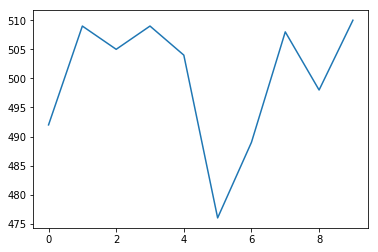

In [19]:
import matplotlib.pyplot as plt
val_y.sum(axis=0).plot()
plt.show()

In [20]:
x=batch_X.values[0:3]
yy=batch_Y.values[0:3]
x.shape[0]

3

In [21]:
x=x.reshape(-1,28,28,1)